In [1]:
#!pip install requests
#!pip install matplotlib
#!pip install pandas
import requests
import zipfile
import os
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
from PIL import Image

#!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import time 
from sklearn.metrics import pairwise_distances
from sklearn.manifold import trustworthiness
from sklearn.neighbors import NearestNeighbors


In [2]:

# Definir caminho base
base_path = "cifar10_dataset"  # Altere para o caminho correto no seu sistema

def carregar_imagens_do_disco(caminho_pasta, modo='train'):
    """
    Carrega imagens do CIFAR-10 a partir de pastas organizadas por classe.
    
    Args:
        caminho_pasta: Caminho para a pasta raiz (ex: 'cifar10_dataset')
        modo: 'train' ou 'test'
    
    Returns:
        X: Array de imagens (n_amostras, 3072)
        y: Array de rótulos (n_amostras,)
    """
    caminho_completo = os.path.join(caminho_pasta, modo)
    classes = os.listdir(caminho_completo)
    imagens = []
    rotulos = []
    
    # Mapear nomes de classes para índices numéricos
    classe_para_indice = {classe: idx for idx, classe in enumerate(classes)}
    
    for classe in classes:
        caminho_classe = os.path.join(caminho_completo, classe)
        if not os.path.isdir(caminho_classe):
            continue  # Ignorar arquivos que não são pastas
        
        # Carregar todas as imagens da classe
        for arquivo in os.listdir(caminho_classe):
            caminho_imagem = os.path.join(caminho_classe, arquivo)
            try:
                img = Image.open(caminho_imagem)
                img_array = np.array(img)  # Formato (32, 32, 3)
                img_array_flat = img_array.flatten()  # Vetor de 3072 elementos (32x32x3)
                imagens.append(img_array_flat)
                rotulos.append(classe_para_indice[classe])
            except Exception as e:
                print(f"Erro ao carregar {caminho_imagem}: {e}")
    
    return np.array(imagens), np.array(rotulos)


In [3]:
# Carregar dados de treino e teste
X_train, y_train = carregar_imagens_do_disco(base_path, modo='train')
X_test, y_test = carregar_imagens_do_disco(base_path, modo='test')


In [4]:
# conjunto de dados BANK 
#bank = fetch_ucirepo(id=222)
df = pd.read_csv('bank+marketing/bank/bank.csv', sep=';')

# One-Hot Encoding para variáveis categóricas
df_encoded = pd.get_dummies(df.drop('y', axis=1))

# Tratar valores ausentes (ex.: substituir -1 em 'pdays')
df_encoded['pdays'] = df_encoded['pdays'].replace(-1, np.nan)
df_encoded['pdays'] = df_encoded['pdays'].fillna(df_encoded['pdays'].median())

# Padronização
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_encoded)


In [29]:
# Configurações
n_execucoes = 5  # Número de execuções do PCA
k_neighbors = 5   # Número de vizinhos para trustworthiness/continuity
results = []      # Lista para armazenar resultados

for run in range(n_execucoes):
    # Iniciar medição de tempo
    start_time = time.time()
    
    # Executar PCA
    pca = PCA(n_components=2, random_state=0)
    principal_components = pca.fit_transform(df_scaled)
    
    # Calcular tempo de execução
    execution_time = time.time() - start_time
    
    # Calcular Stress
    original_distances = pairwise_distances(df_scaled, metric='euclidean')
    pca_distances = pairwise_distances(principal_components, metric='euclidean')
    
    stress_numerator = np.sum((original_distances - pca_distances)**2)
    stress_denominator = np.sum(original_distances**2)
    stress = np.sqrt(stress_numerator / stress_denominator)
    
    # Calcular Trustworthiness
    trust = trustworthiness(df_scaled, principal_components, n_neighbors=k_neighbors)
    
    # Calcular Continuity
    nbrs_original = NearestNeighbors(n_neighbors=k_neighbors).fit(df_scaled)
    _, indices_original = nbrs_original.kneighbors(df_scaled)
    
    nbrs_pca = NearestNeighbors(n_neighbors=k_neighbors).fit(principal_components)
    _, indices_pca = nbrs_pca.kneighbors(principal_components)
    
    continuity = 0
    n = df_scaled.shape[0]
    for i in range(n):
        common_neighbors = len(set(indices_original[i]).intersection(set(indices_pca[i])))
        continuity += common_neighbors / k_neighbors
    continuity /= n
    
    # Salvar resultados
    results.append({
        'execucao': run + 1,
        'tempo_execucao': execution_time,
        'stress': stress,
        'trustworthiness': trust,
        'continuity': continuity
    })

# Criar DataFrame com os resultados
df_results = pd.DataFrame(results)

# Salvar em CSV para uso futuro
df_results.to_csv('resultados/pca/metricas_pca.csv', index=False)

print(df_results)

   execucao  tempo_execucao   stress  trustworthiness  continuity
0         1        0.003827  0.69604         0.731455    0.313161
1         2        0.004461  0.69604         0.731455    0.313161
2         3        0.002479  0.69604         0.731455    0.313161
3         4        0.002872  0.69604         0.731455    0.313161
4         5        0.002779  0.69604         0.731455    0.313161


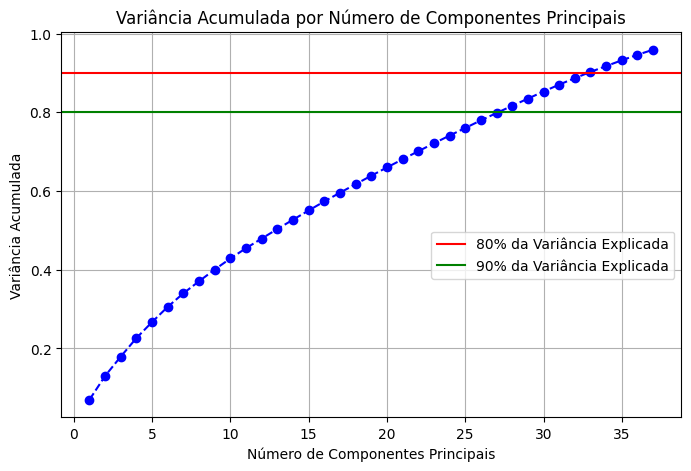

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Número de Componentes Principais')    
plt.ylabel('Variância Acumulada')
plt.title('Variância Acumulada por Número de Componentes Principais')
plt.axhline(y=0.9, color='r', linestyle='-', label='80% da Variância Explicada')  # Linha de referência para 90% da variância explicada
plt.axhline(y=0.8, color='g', linestyle='-', label='90% da Variância Explicada')  # Linha de referência para 80% da variância explicada
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.savefig("PCA_variancia_PCs_2.png", dpi=300)
plt.show()